In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.chdir("/home/ksaab/Documents/domino")
from domino.data.cxr import build_cxr_df, get_dp
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from gaze_utils import plot_saccade, generate_ideal_observer

211102-14:23:53,640 nipype.utils WARNING:
	 A newer version (1.7.0) of nipy/nipype is available. You are using 1.6.0


/home/ksaab/Documents/meerkat/meerkat/nn/__init__.py:7: ExperimentalWarning: The `meerkat.nn` module is experimental and has limited test coverage. Proceed with caution.
  warnings.warn(


## Get CXR datapanel

In [3]:
df = build_cxr_df(root_dir="/media/4tb_hdd/siim")  # .out(load=True)
dp = get_dp(df)

In [4]:
dp.keys()

['image_id',
 'encoded_pixels',
 'pmx',
 'filepath',
 'chest_tube',
 'split',
 'gaze_seq',
 'gaze_max_visit',
 'gaze_unique',
 'gaze_time',
 'gaze_diffusivity',
 'expert_label',
 'padded_gaze_seq',
 'gaze_seq_len',
 'index',
 'input',
 'img',
 'segmentation_mask']

In [5]:
tube_mask = dp["chest_tube"].data.astype(str) != "nan"
dp = dp.lz[tube_mask]

test_mask = np.array(dp["split"].data=="test") #np.logical_and(~train_mask, ~np.isnan(dp["chest_tube"]))
train_mask = np.array(dp["split"].data=="train") #np.logical_and(~test_mask,dp["chest_tube"].data.astype(str) != "nan") #~np.isnan(dp["gaze_seq"].data) #dp["gaze_seq"].data != "nan"

## Plot image with segmentation mask and saccade

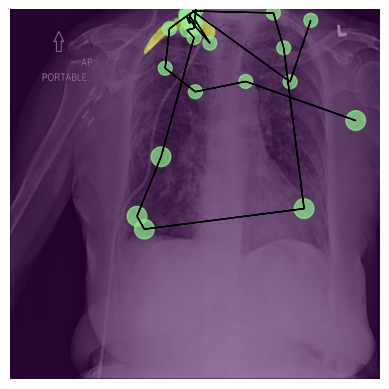

In [6]:
dp_pos = dp.lz[dp["pmx"]==1]

ndx=0

img = dp_pos[ndx]["img"]

seg_mask = dp_pos[ndx]["segmentation_mask"]
seg_mask = Image.fromarray(np.uint8(seg_mask))

gaze_seq = dp_pos[ndx]["gaze_seq"]

plt.imshow(img, cmap="gray")
plt.imshow(seg_mask, alpha=0.5)
plot_saccade(gaze_seq)

plt.axis("OFF")
plt.show()

## Simulate ideal searcher

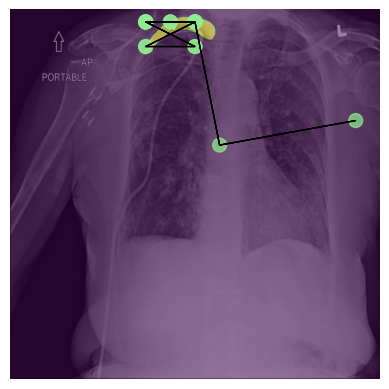

In [7]:
# define the hyperparameters for the detectibility map
alpha = 2 #3.28 used in rashidi et al.
beta = 5 # random guess for now
threshold = 0.99 # threshold for stopping the search

# define resolution of image
p = 15

# use same starting point as radiologist
human_seq = gaze_seq.numpy()
starting_loc = (human_seq[0][0], human_seq[0][1])


ideal_gaze_seq = generate_ideal_observer(starting_loc, alpha, beta, dp_pos[ndx]["segmentation_mask"], p, threshold)

plt.imshow(img, cmap="gray")
plt.imshow(seg_mask, alpha=0.5)
plot_saccade(np.array(ideal_gaze_seq))

plt.axis("OFF")
plt.show()

### sweep over detectability params

In [11]:
alpha_vals = [1,3]#1,2,4]
num_trials = 5
p = 10
beta=3
threshold=0.99
c=0.02

fig, axs = plt.subplots(num_trials,len(alpha_vals), figsize=(30,20))
for ndx, alpha in enumerate(alpha_vals):

    for i in range(num_trials):
        ideal_gaze_seq = generate_ideal_observer(starting_loc, alpha, beta, dp_pos[ndx]["segmentation_mask"], p, threshold, c=c)

        axs[i,ndx].imshow(img, cmap="gray")
        axs[i,ndx].imshow(seg_mask, alpha=0.5)
        plot_saccade(np.array(ideal_gaze_seq), 200, axs[i,ndx])
        axs[i,ndx].axis("off")
        if i == 0:
            axs[i,ndx].set_title(f"alpha={alpha}", fontsize=40)


plt.tight_layout()
plt.show()